# Лабораторная работа №10 “Градиентный бустинг”


In [130]:
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from scipy import misc
from datetime import datetime
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import scipy.optimize
from scipy import stats
from sklearn.tree import *
from sklearn.ensemble import *


import math
from sklearn.model_selection import train_test_split

## 1. Загрузите данные с помощью библиотеки sklearn.


In [131]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
X = boston_dataset["data"]
y = boston_dataset["target"]

## 2. Разделите выборку на обучающую (75%) и контрольную (25%).


In [143]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=42)

## 3. Заведите массив для объектов DecisionTreeRegressor (они будут использоваться в качестве базовых алгоритмов) и для вещественных чисел (коэффициенты перед базовыми алгоритмами).

## 4. В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X. Реализуйте ее. Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics.


In [133]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

def grad(z, y):
    return y - z

def gbm_predict(X, base_algorithms_list, coefficients_list):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

In [134]:
def gbm_train(X_train, y_train, max_depth=5, iters=50, coef=0.9):
    algos, coefs = [], []
    
    target = y_train
    for i in range(iters):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        tree.fit(X_train, target)
        algos.append(tree)
        
        if isinstance(coef, (int, float)):
            coefs.append(coef)
        else:
            coefs.append(coef(i))
            
        target = grad(gbm_predict(X_train, algos, coefs), y_train)
        
    return algos, coefs

## 5. В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с отклонением истинных значений от предсказанных.

In [135]:
algos, coefs = gbm_train(X_train, y_train)
mean_squared_error(y_test, gbm_predict(X_test, algos, coefs))

13.577188945603083

## 6. Попробуйте всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но на стандартном наборе данных будет всего 50 деревьев, возьмите для начала шаг побольше.


In [136]:
algos, coefs = gbm_train(X_train, y_train)
mean_squared_error(y_test, gbm_predict(X_test, algos, coefs))

13.577188945603083

## 8. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Какое получилось качество на контрольной выборке?

In [137]:
algos, coefs = gbm_train(X_train, y_train, coef=lambda i: 0.9 / (1.0 + i))
mean_squared_error(y_test, gbm_predict(X_test, algos, coefs))

8.932778786389141

## 9. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций, а также с ростом глубины деревьев. Постройте графики. Какие выводы можно сделать?

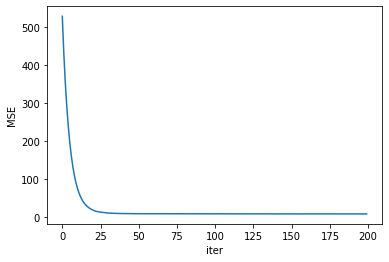

In [139]:
algos, coefs = gbm_train(X_train, y_train, coef=lambda i: 0.1, iters=200)

metrics = []

for i in range(200):
    pred = gbm_predict(X_test, algos[:i], coefs[:i])
    mse = mean_squared_error(y_test, pred)
    metrics.append(mse)
    

plt.plot(np.arange(200), metrics)
plt.xlabel('iter')
plt.ylabel('MSE');

Как видим, градиентный бустинг не переобучается с ростом кол-ва итераций

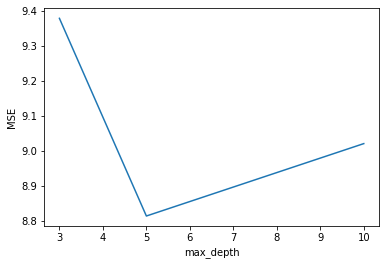

In [116]:
metrics = []

for depth in [3, 5, 10]:
    algos, coefs = gbm_train(X_train, y_train, coef=lambda i: 0.1, max_depth=depth)
    mse = mean_squared_error(y_test, gbm_predict(X_test, algos, coefs))
    metrics.append(mse)

plt.plot([3, 5, 10], metrics)
plt.xlabel('max_depth')
plt.ylabel('MSE');

Как видим, градиентный бустинг переобучается с ростом глубины деревьев

## 10. Сравните качество, получаемое с помощью градиентного бустинга с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке RMSE.


In [144]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)
mean_squared_error(y_test, lr.predict(X_test))

22.098694827098424